In [1]:
# Preprocessors
import copy
import os

from preprocessing.Preprocessors import *
from preprocessing.Paint_Extractor_Preprocessor import *
from preprocessing.Noise_Extractor_Preprocessor import *
from preprocessing.Color_Preprocessor import *
from preprocessing.Text_Extractor_Preprocessor import *

# Descriptors
from descriptors.Color_Descriptors import *
from descriptors.Text_Descriptors import *
from descriptors.Texture_Descriptors import *
from descriptors.Filtering_Descriptors import *

#CORE
from core.CoreImage import *

#Utils
from utils import utils
from utils.distance_metrics import *


## Auxiliar imports
from pathlib import Path
from tqdm import tqdm
from PIL import Image
import  matplotlib.pyplot as plt

In [62]:
def harmonize_tokens(text):
    final_text = []
    if len(text) > 0:
        for t in text:
            t = t.split(" ")
            for st in t:
                ext = [c for c in st if c.isalpha()]
                ext = "".join(ext)
                if len(ext) > 0:
                    final_text.append(ext)
    final_text = sorted(final_text)
    final_text = " ".join(final_text)

    return final_text

In [63]:
utils.read_author_bbdd("../data/BBDD")
BBDD_AUTHORS = sorted(utils.read_author_bbdd("../data/BBDD"))


In [65]:
with open(str(BBDD_AUTHORS[0]), "r") as f:
    a = (f.readline().strip().split(","))
    if len(a) != 0:
        a = a[0]
        author = (a[1:].split(",")[0]).split(" ")
        print(author)
        harmo_authors = harmonize_tokens(author)
        
    else:
        harmo_authors = "Unkown"

["'Victor", "Perez-Porros'"]


In [66]:
harmo_authors

'PerezPorros Victor'

In [148]:
def refine_mask(image):
    # Enhancement of the external edges
    rg_chrom = Color_Preprocessor.convert2rg_chromaticity(image)
    enhanced = ((rg_chrom + utils.sharpening(rg_chrom)) * 255).astype("uint8")
    enhanced = (enhanced[:, :, 0] + enhanced[:, :, 1]) // 2

    ## applying the derivates (sobel)
    edge = utils.Sobel_magnitude(enhanced, x_importance=6, y_importance=6)

    thr = filters.threshold_otsu(edge)
    edge = (edge > thr).astype(np.uint8)
    edge = utils.apply_closing(edge, (5, 5))
    edge = cv2.medianBlur(edge, 5)

    ## Apply hough transform
    mask = np.zeros_like(edge)
    min_shape = min(edge.shape[0], edge.shape[1])
    max_line_gap = int(min_shape * 0.02)
    h_, w_ = edge.shape
    votes_min_l = int(min(h_ * 0.05, w_ * 0.05))

    linesP = cv2.HoughLinesP(edge, 1, np.pi / 180, votes_min_l, minLineLength=votes_min_l, maxLineGap=max_line_gap)

    if linesP is not None:
        for i in range(0, len(linesP)):
            l = linesP[i][0]
            cv2.line(mask, (l[0], l[1]), (l[2], l[3]), 255, 3, cv2.LINE_AA)

    # Getting the contour
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    decission = []
    heigh_im, width_im = edge.shape


    ## Getting the final bbox
    new_mask = np.zeros_like(edge)
    absolut_area = new_mask.shape[0] * new_mask.shape[1]

    for contour in contours:
        convexHull = cv2.convexHull(contour)

        perimeter = cv2.arcLength(convexHull, True)
        x, y, w, h = cv2.boundingRect(convexHull)
        aspect_ratio = w / h
        area = w * h
        proportion_height = h / heigh_im
        proportion_width = w / width_im

        if (proportion_height > 0.15) and (proportion_width > 0.15) and width_im  and (area> absolut_area * 0.75):
            decission.append(([y, x, h, w], perimeter, area, aspect_ratio))

    decission = sorted(decission, key=lambda x: x[2], reverse=True)
    decission = utils.non_maximun_supression(decission)

    if len(decission) != 0:
        new_bbox = decission[0][0]
        y, x, h, w = new_bbox
        new_mask[y:y + h, x:x + w] = 1

    else:
        new_bbox = [0,0,0,0]
        new_mask = np.ones_like(new_mask)
        

    return new_bbox, new_mask


In [149]:
queries = utils.read_pickle("../data/qst1_w4/qst1_w4_processed.pkl")

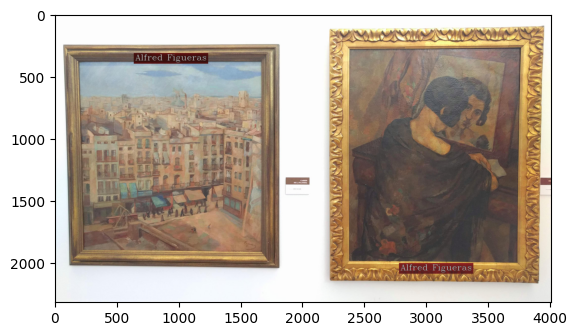

In [207]:
plt.imshow(queries[33].image)

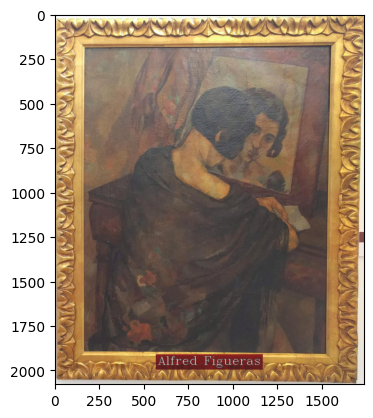

In [209]:
paint = queries[33][1]._paint
plt.imshow(paint)

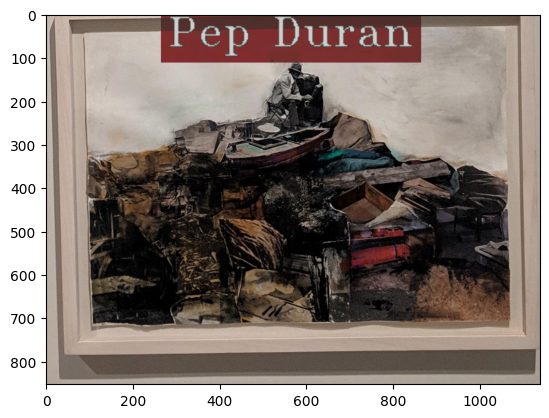

In [140]:
y,x,h,w = (refine_mask(paint)[0])

if not y == x == h == w:
    plt.imshow(paint[y:y+h,x:x+w])
else:
    plt.imshow(paint)


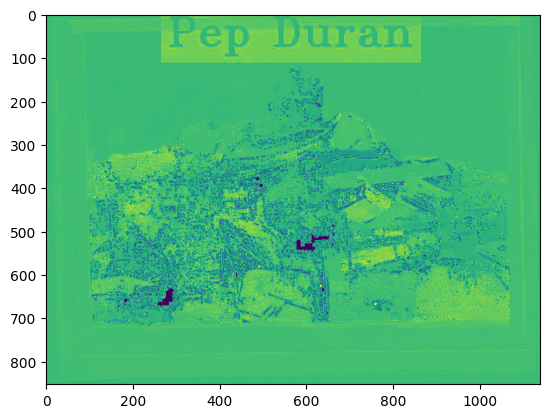

In [141]:
rg_chrom = Color_Preprocessor.convert2rg_chromaticity(paint)
enhanced = ((rg_chrom + utils.sharpening(rg_chrom)) * 255).astype("uint8")
enhanced = (enhanced[:, :, 0] + enhanced[:, :, 1]) // 2
plt.imshow(enhanced)

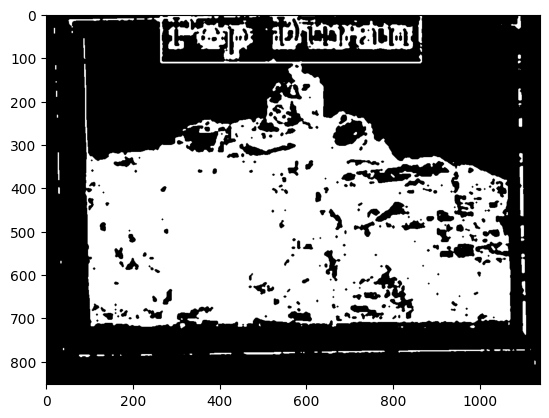

In [142]:
## applying the derivates (sobel)
edge = utils.Sobel_magnitude(enhanced, x_importance=6, y_importance=6)

thr = filters.threshold_otsu(edge)
edge = (edge > thr).astype(np.uint8)
edge = utils.apply_closing(edge, (5,5))
edge = cv2.medianBlur(edge, 5)
#edge = utils.apply_erode(edge, (3,3))
plt.imshow(edge, cmap="gray")

In [143]:
## Apply hough transform
mask = np.zeros_like(edge)
min_shape = min(edge.shape[0], edge.shape[1])
max_line_gap = int(min_shape * 0.02)
h_, w_ = edge.shape
votes_min_l = int(min(h_ * 0.05, w_ * 0.05))

linesP = cv2.HoughLinesP(edge, 1, np.pi / 180, votes_min_l, minLineLength=votes_min_l, maxLineGap=max_line_gap)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(mask, (l[0], l[1]), (l[2], l[3]), 255, 3, cv2.LINE_AA)



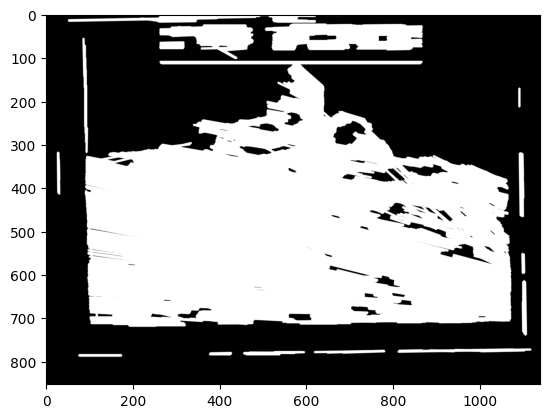

In [144]:
plt.imshow(mask, cmap="gray")

In [146]:
# Getting the contour
contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
decission = []
heigh_im, width_im = edge.shape


## Getting the final bbox
new_mask = np.zeros_like(edge)
absolut_area = new_mask.shape[0] * new_mask.shape[1]

for contour in contours:
    convexHull = cv2.convexHull(contour)

    perimeter = cv2.arcLength(convexHull, True)
    x, y, w, h = cv2.boundingRect(convexHull)
    aspect_ratio = w / h
    area = w * h
    proportion_height = h / heigh_im
    proportion_width = w / width_im

    if (proportion_height > 0.15) and (proportion_width > 0.15) and width_im and (area > absolut_area * 0.7):
        decission.append(([y, x, h, w], perimeter, area, aspect_ratio))

decission = sorted(decission, key=lambda x: x[2], reverse=True)
decission = utils.non_maximun_supression(decission)

if len(decission) != 0:
    new_bbox = decission[0][0]
    y, x, h, w = new_bbox
    new_mask[y:y + h, x:x + w] = 1

else:
    new_bbox = [0,0,0,0]
    new_mask = np.ones_like(new_mask)

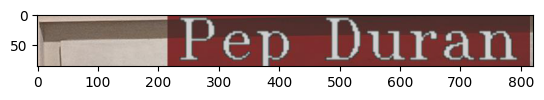

In [147]:
plt.imshow(paint[y:y+h,x:x+w])